## Predictions and Ensembling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
import seaborn as sns
import os

import sklearn
import os 
from PIL import Image
  
import os,cv2
from IPython.display import Image

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model


## Loading Test Dataset

In [2]:
test_labels = pd.read_csv("../input/jantahackcomputervision/test_vc2kHdQ.csv")
submission = pd.read_csv("../input/jantahackcomputervision/ss.csv")

submission["emergency_or_not"] = submission["emergency_or_not"].astype(str)

random = [ '0' if i%4==0 else '1' for i in range(706)]
submission["emergency_or_not"]  = random

In [3]:
submission.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,1
3,808.jpg,1
4,1907.jpg,0


In [4]:
# prepare data augmentation configuration for test dataset
def return_test_data_generator(img_width,img_height,batch_size=16):

    img_dir = "../input/jantahackcomputervision/train_SOaYf6m/images"
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_dataframe(dataframe=test_labels,directory=img_dir,x_col='image_names',
                                            class_mode=None,batch_size=batch_size,
                                            target_size=(img_width,img_height),shuffle=False)

    return test_generator

In [5]:
## Function for making predictions

def make_predictions(model,test_generator,filename):
    img_dir = "../input/jantahackcomputervision/train_SOaYf6m/images"
    submission = pd.read_csv("../input/jantahackcomputervision/ss.csv")
    
    ## Normal Predictions
    predictions = model.predict(test_generator,verbose=1)
    predictions = np.squeeze((predictions>0.5).astype('int'))
    predictions[:5]
    submission["emergency_or_not"] = predictions
    submission.to_csv("./"+filename+".csv",index=False)
    return submission
    

In [6]:
# Function for plotting predictions

from PIL import Image
def view_predictions(df,rows,cols):
    IMAGE_DIR ="../input/jantahackcomputervision/train_SOaYf6m/images/"
    axes=[]
    fig=plt.figure(figsize=(16,12))    
    for i in range(rows*cols):
        idx = np.random.randint(len(df), size=1)[0]
        image_name , label = df.loc[idx,"image_names"],df.loc[idx,"emergency_or_not"]
        image = Image.open(IMAGE_DIR+image_name)
        label = "emergency" if label==1 else "non-emergency"
        axes.append( fig.add_subplot(rows, cols, i+1))
        subplot_title=("Category :"+str(label))
        axes[-1].set_title(subplot_title)  
        plt.imshow(image)
    fig.tight_layout()  
    plt.show()
        




## Predictions for fine tuned VGG16

In [7]:
test_gen = return_test_data_generator(224,224)
vgg_finetune = load_model("../input/cv-av-models/fine_tuned.hdf5")
vgg_finetune_subm = make_predictions(vgg_finetune,test_gen,"vgg_finetune")

Found 706 validated image filenames.
45/45 [==============================] - 3s 66ms/step


###  VGG16 fine tuned with augmentations and regularization

In [8]:
## Loading predictions of vgg finetuned with l2 
vgg_finetune_l2_subm = pd.read_csv("../input/cv-av-models/fine_tuned_l2.csv")
vgg_finetune_l2_subm.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,1
4,1907.jpg,0


### Predictions for NASnet large

In [9]:
test_gen = return_test_data_generator(331,331)
nasnet = load_model("../input/cv-av-models/nasnet.hdf5")
nasnet_subm = make_predictions(nasnet,test_gen,"nasnet")

Found 706 validated image filenames.
45/45 [==============================] - 14s 308ms/step


 ### Predictions for NASnet large with l2 and dropout

In [10]:
test_gen = return_test_data_generator(331,331)
nasnet_l2 = load_model("../input/cv-av-models/nasnet_l2.hdf5")
nasnet_l2_subm = make_predictions(nasnet_l2,test_gen,"nasnet_l2")

Found 706 validated image filenames.
45/45 [==============================] - 14s 302ms/step


 ### CNN architecture with 5 folds

In [12]:
cnn_fold_subm = pd.read_csv("../input/cv-av-models/cnn_fold.csv")

## Ensembling above 5 models
Ensemble learning combines the predictions from multiple models to reduce the variance of predictions and reduce generalization error.

We referred the following article it explains ensembling in detail :-<br>
https://machinelearningmastery.com/ensemble-methods-for-deep-learning-neural-networks/

In [13]:
vgg_finetune_subm.drop("image_names",axis=1,inplace=True)
vgg_finetune_subm.rename(columns={"emergency_or_not":"vgg_finetune"},inplace=True)

vgg_finetune_l2_subm.drop("image_names",axis=1,inplace=True)
vgg_finetune_l2_subm.rename(columns={"emergency_or_not":"vgg_finetune_l2"},inplace=True)

nasnet_subm.drop("image_names",axis=1,inplace=True)
nasnet_subm.rename(columns={"emergency_or_not":"nasnet"},inplace=True)

nasnet_l2_subm.drop("image_names",axis=1,inplace=True)
nasnet_l2_subm.rename(columns={"emergency_or_not":"nasnet_l2"},inplace=True)

cnn_fold_subm.drop("image_names",axis=1,inplace=True)
cnn_fold_subm.rename(columns={"emergency_or_not":"cnn_fold"},inplace=True)

In [14]:
## Mostly all the models have same predictions but wherever one model is better than other 
## that would get compensated when  ensembled.

concat = pd.concat([vgg_finetune_subm,vgg_finetune_l2_subm,nasnet_subm,nasnet_l2_subm,cnn_fold_subm],axis=1)
concat.sample(5)



,vgg_finetune,vgg_finetune_l2,nasnet,nasnet_l2,cnn_fold
509,0,0,0,0,0
90,0,0,0,0,0
521,0,0,0,0,0
215,1,1,1,1,1
29,1,1,1,1,0


In [15]:
submission["emergency_or_not"] = concat.mode(axis=1)[0]
submission.to_csv("./nasnet_fineTuneSGD_ensemble.csv",index=False)
submission.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,1
4,1907.jpg,0


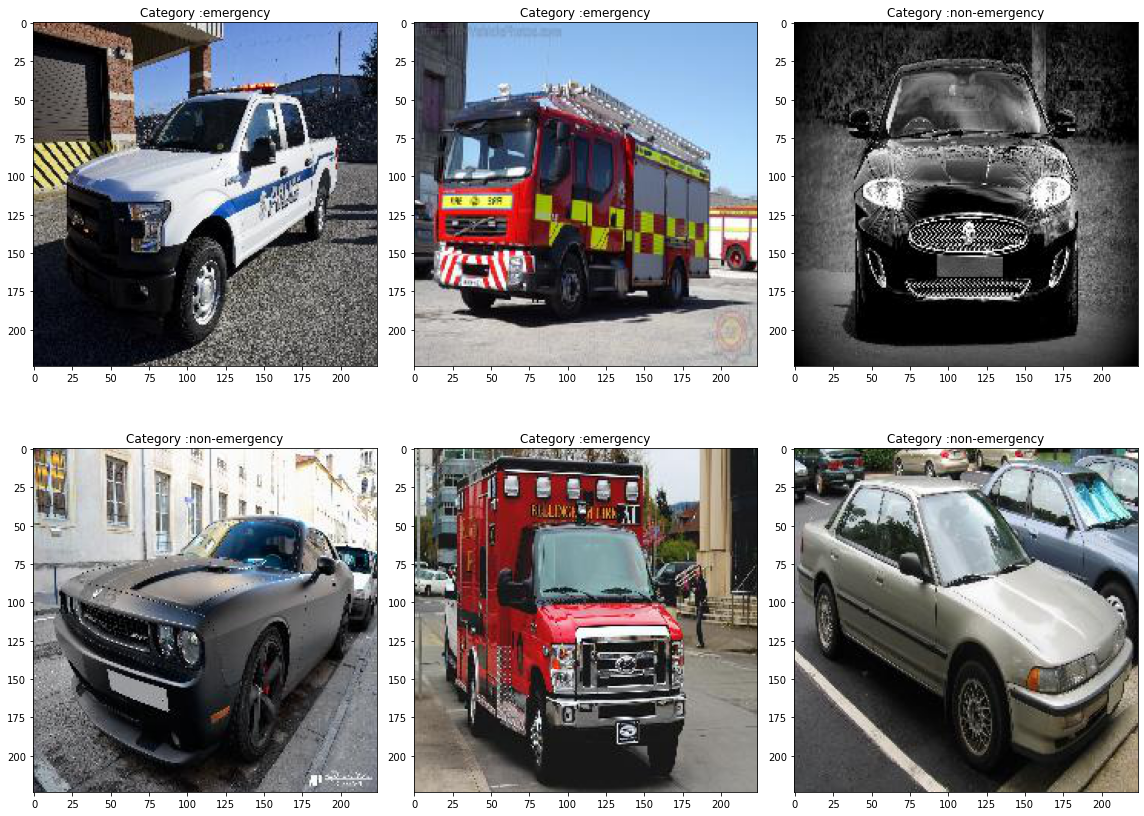

In [16]:
view_predictions(submission,2,3)

## Model Comparison 
- Based on accuracy achieved on the leaderboard

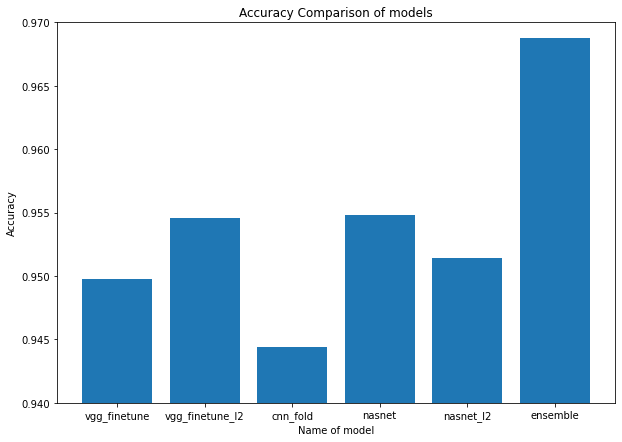

In [17]:
model = ["vgg_finetune","vgg_finetune_l2","cnn_fold","nasnet","nasnet_l2","ensemble"]
acc = [0.9498,0.9546,0.9444,0.9548,0.9514,0.9688]

   
fig = plt.figure(figsize = (10, 7)) 
  
# creating the bar plot 
plt.bar(model, acc) 
plt.ylim(0.94,0.97)

plt.xlabel("Name of model") 
plt.ylabel("Accuracy") 
plt.title("Accuracy Comparison of models") 
plt.show() 